In [13]:
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import lightkurve as lk
import threemultis
import matplotlib.pyplot as plt
from copy import deepcopy
from astropy.io import fits
import os

In [15]:
# Trim out some pixels which have a bleed column on them
raw_tpf = lk.search_targetpixelfile('K2-43').download()
hdu = deepcopy(raw_tpf.hdu)
for name in hdu[1].columns.names:
    if (len(hdu[1].data[name].shape) == 3):
        hdu[1].data[name][:, :, :4] = np.nan
fits.HDUList(hdus=list(hdu)).writeto('hack.fits', overwrite=True)
tpf = lk.KeplerTargetPixelFile('hack.fits', quality_bitmask=raw_tpf.quality_bitmask)
os.remove('hack.fits')

/Users/ch/miniconda3/lib/python3.6/site-packages/astropy/io/fits/fitsrec.py:684: UserWarning: Field 12 has a repeat count of 0 in its format code, indicating an empty field.
  'indicating an empty field.'.format(key))
/Users/ch/miniconda3/lib/python3.6/site-packages/astropy/io/fits/fitsrec.py:684: UserWarning: Field 'RB_LEVEL' has a repeat count of 0 in its format code, indicating an empty field.
  'indicating an empty field.'.format(key))


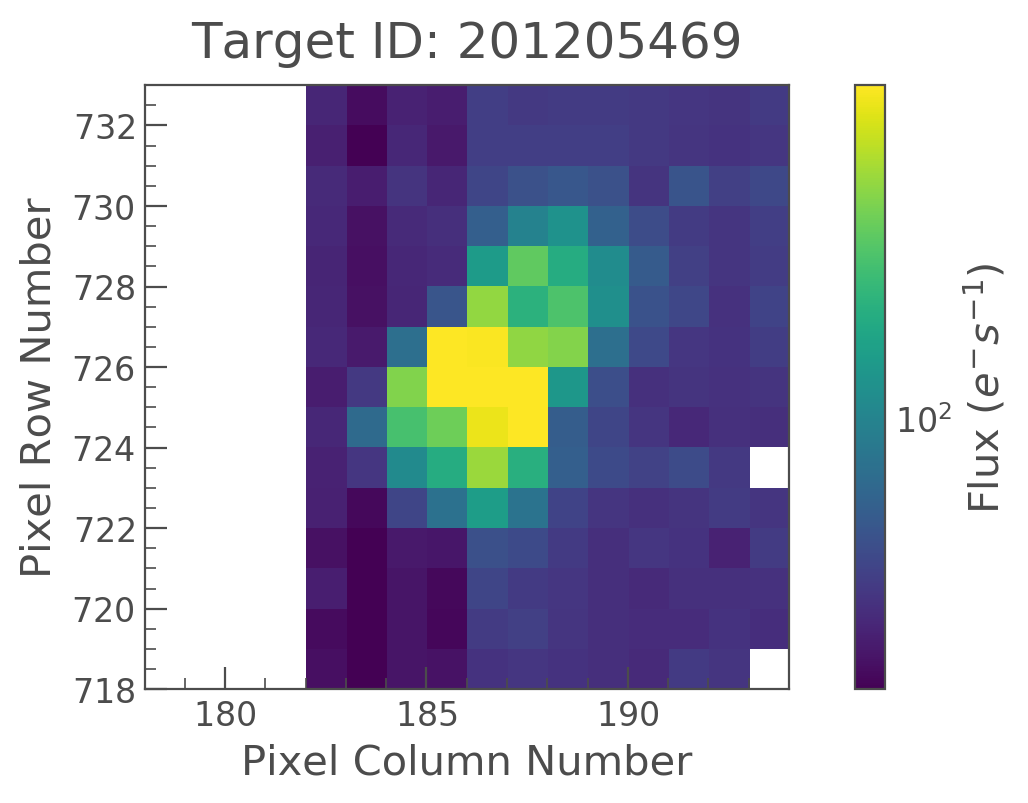

In [16]:
tpf.plot(frame=1000, scale='log')

In [17]:
tpf = tpf[10:]
tpf = tpf[np.in1d(tpf.time, tpf.to_lightcurve(aperture_mask='all').remove_nans().time)]
tpf = tpf[tpf.to_lightcurve().normalize().flux > 0.8]


mask = threemultis.utils.planet_mask(tpf.time, 'K2-43')
aper = np.nan_to_num(np.nanpercentile(tpf.flux, 95, axis=(0))) > 50

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [18]:
# First pass, remove some very bad outliers
bad = np.zeros(len(tpf.time), bool)
for count in range(2):
    pld_lc = tpf[~bad].to_corrector('pld').correct(aperture_mask=aper, cadence_mask=mask[~bad])
    pld_lc = pld_lc.flatten(31, mask=~mask[~bad])
    bad |= np.in1d(tpf.time, pld_lc.time[np.abs(pld_lc.flux - 1) > 5 * np.std(pld_lc.flux - 1)])
    
tpf = tpf[~bad]
mask = mask[~bad]

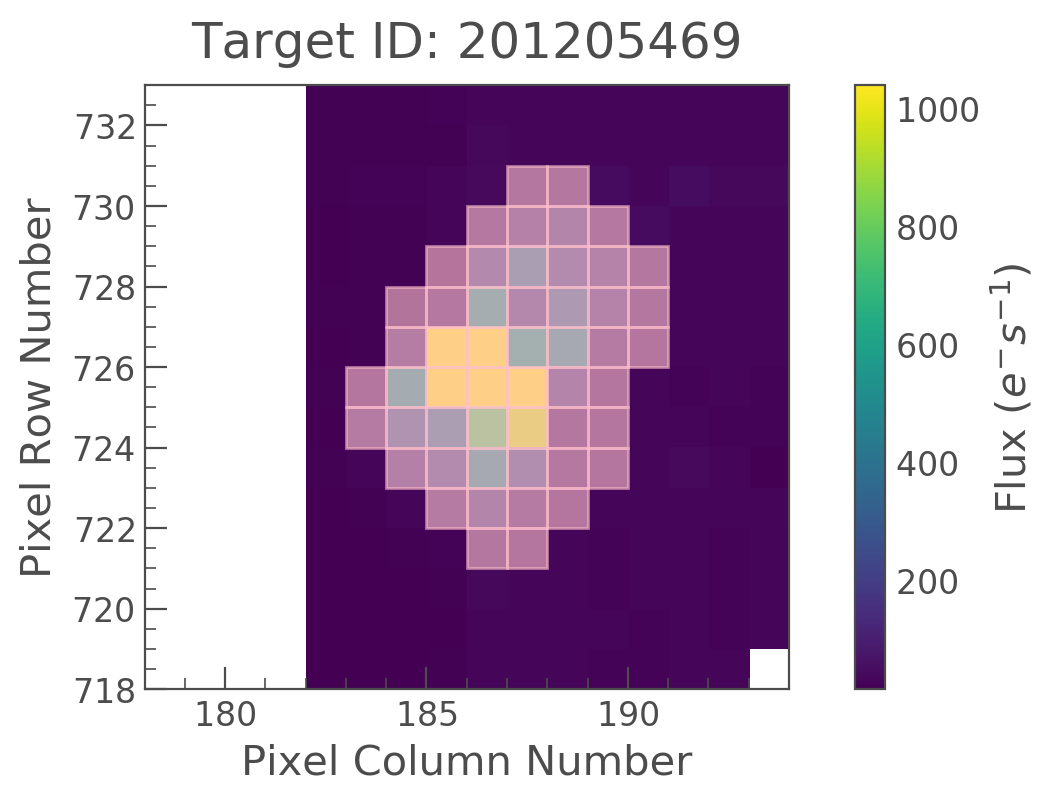

In [19]:
tpf.plot(aperture_mask=aper)

In [20]:
np.nanmin(tpf.flux_err)

1.1182841

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
100%|██████████| 50/50 [03:07<00:00,  3.75s/it]


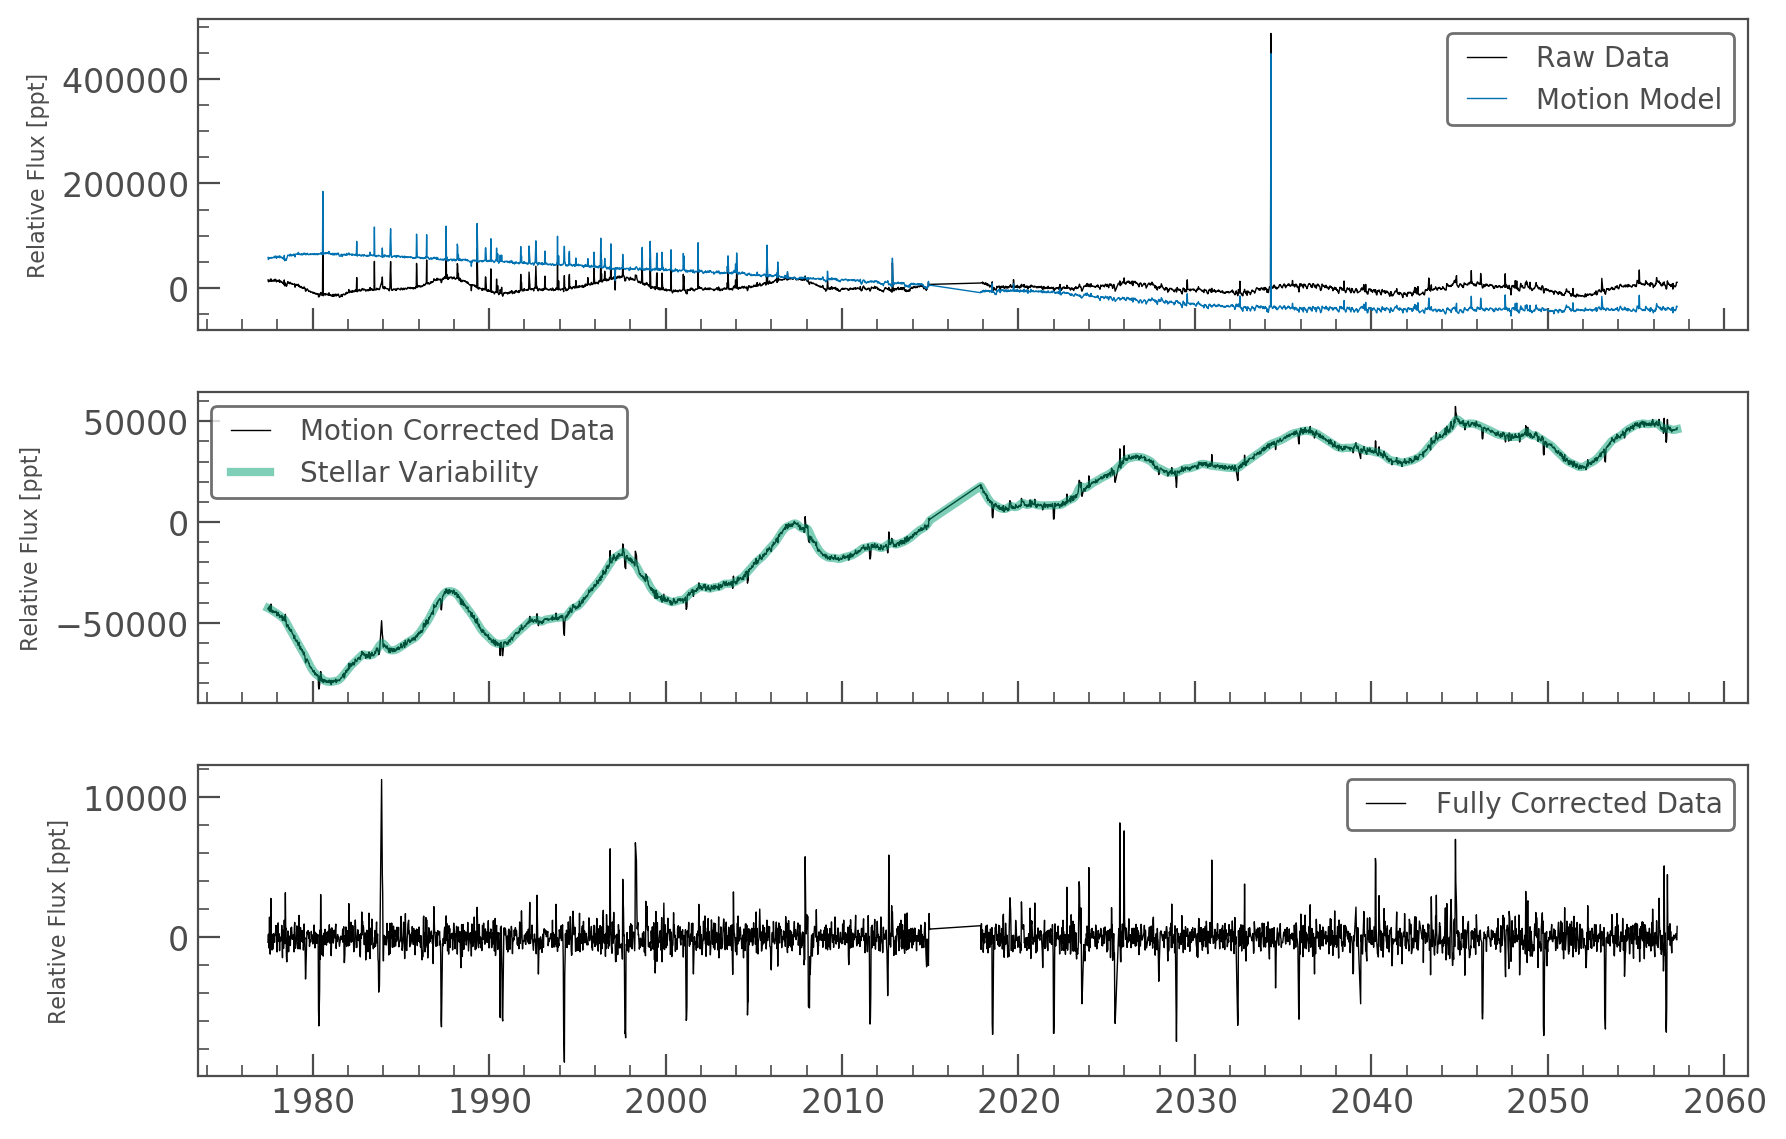

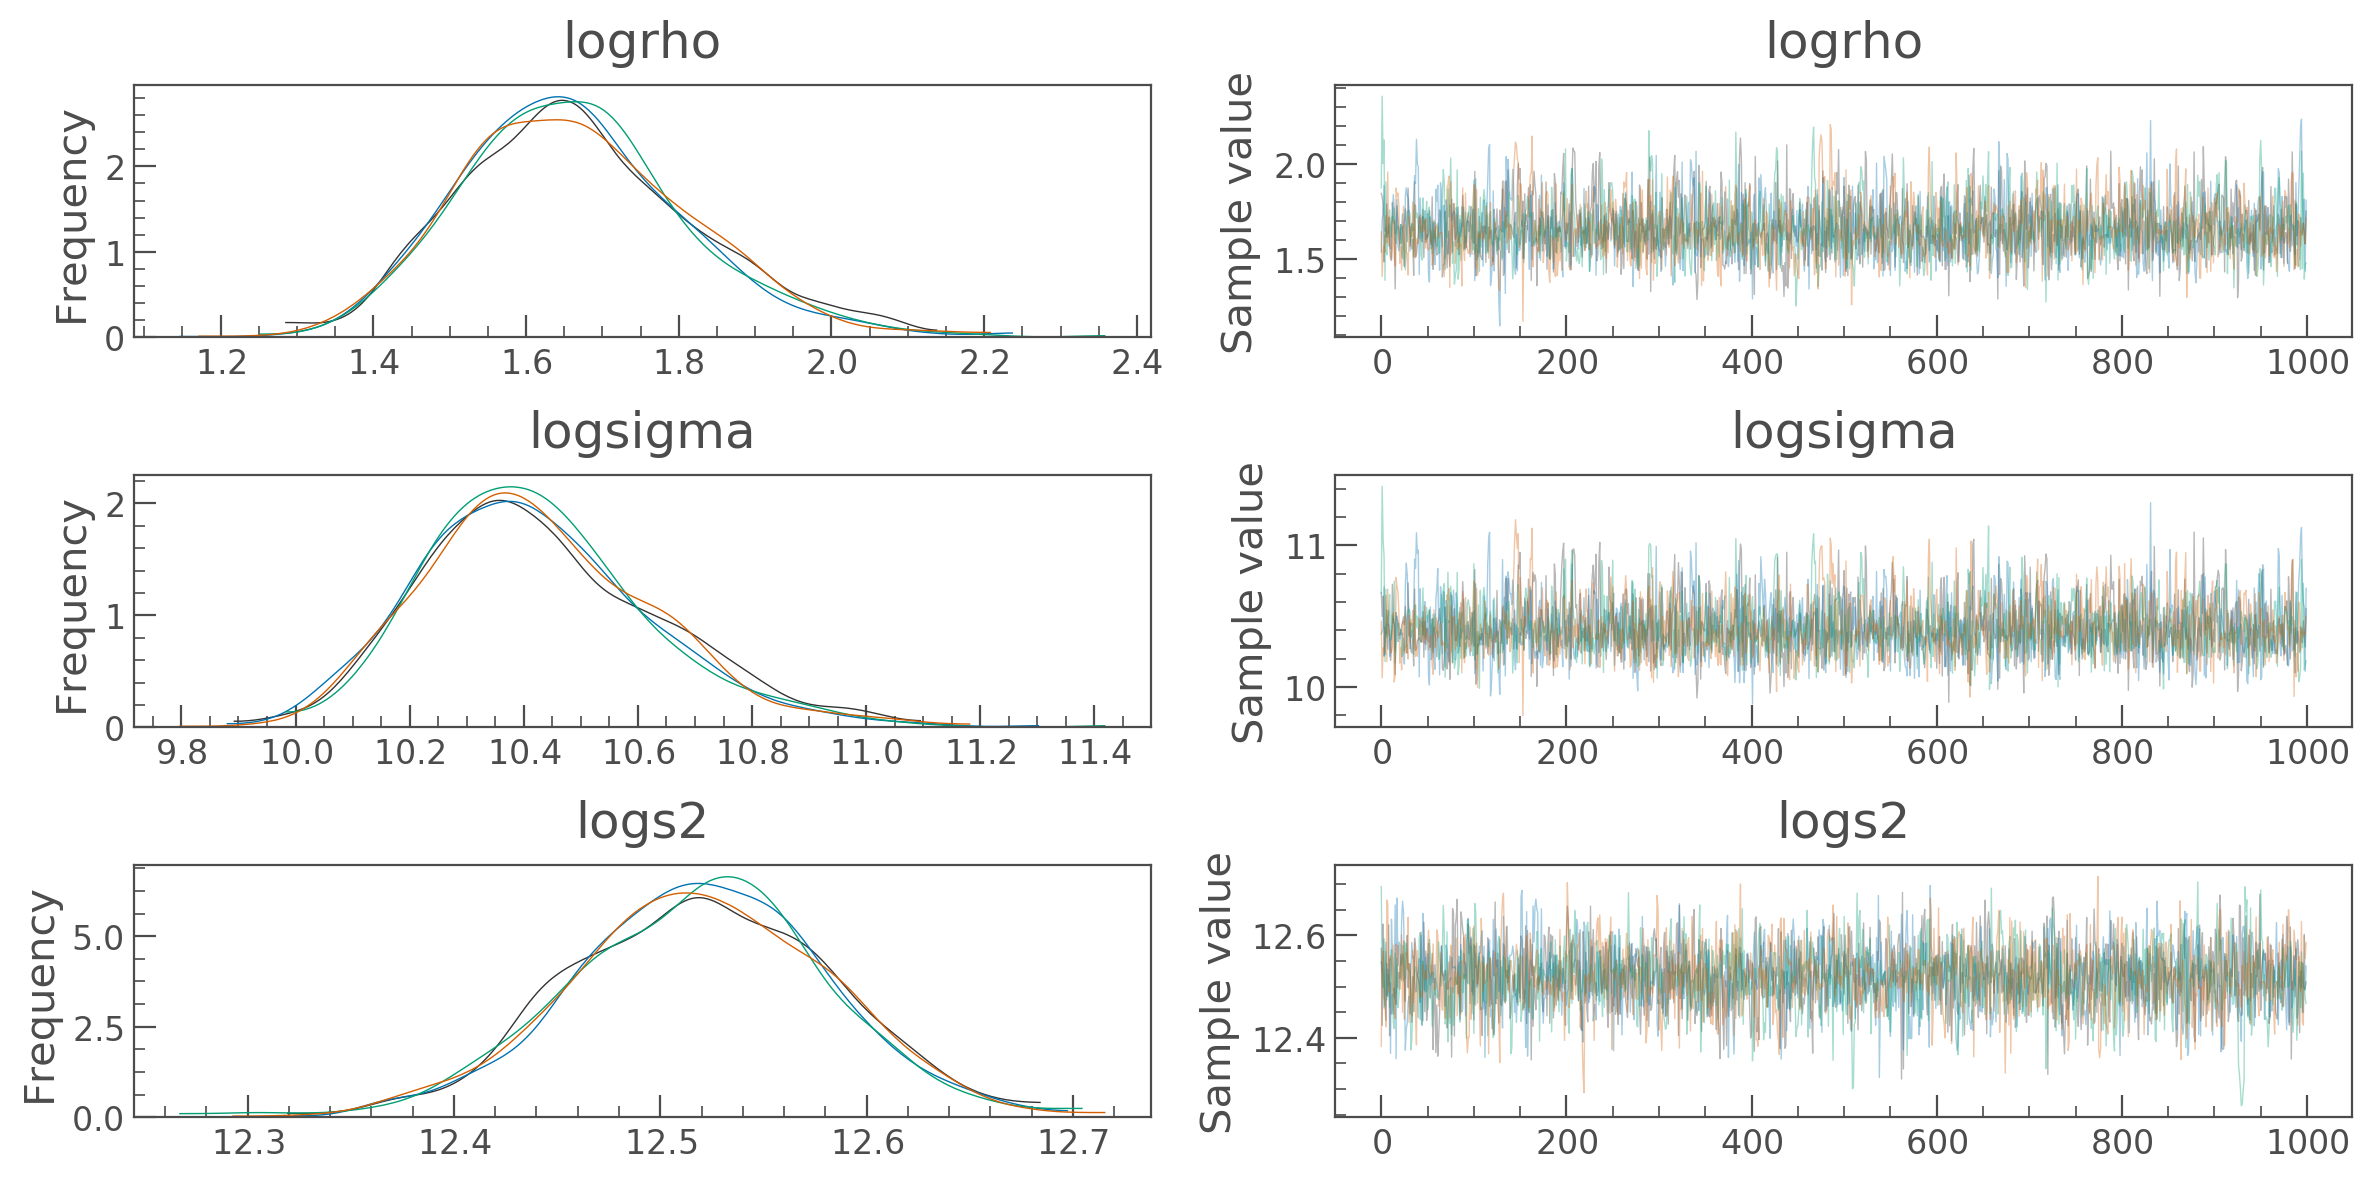

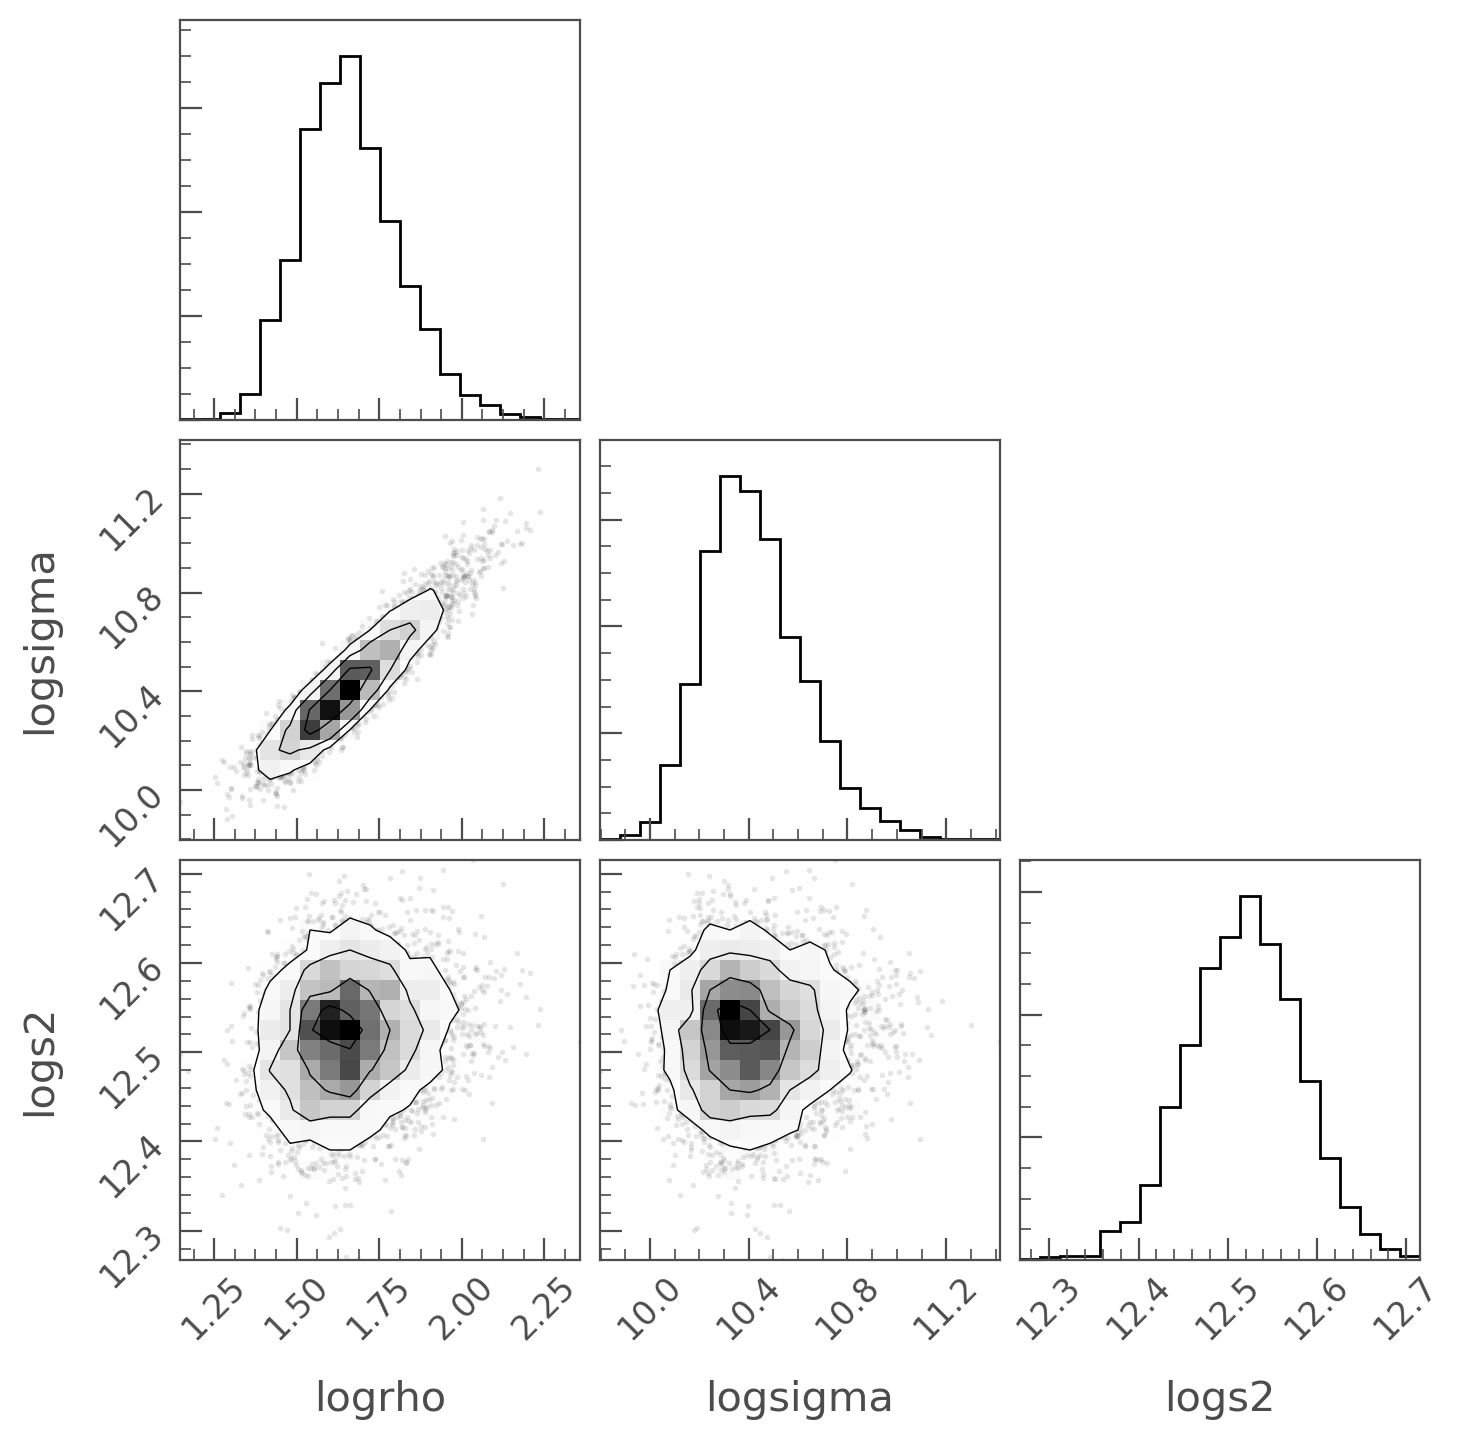

In [21]:
clc = threemultis.fit.PLD(tpf, planet_mask=mask, trim=1, aperture=aper, 
                          logrho_mu=np.log(30))

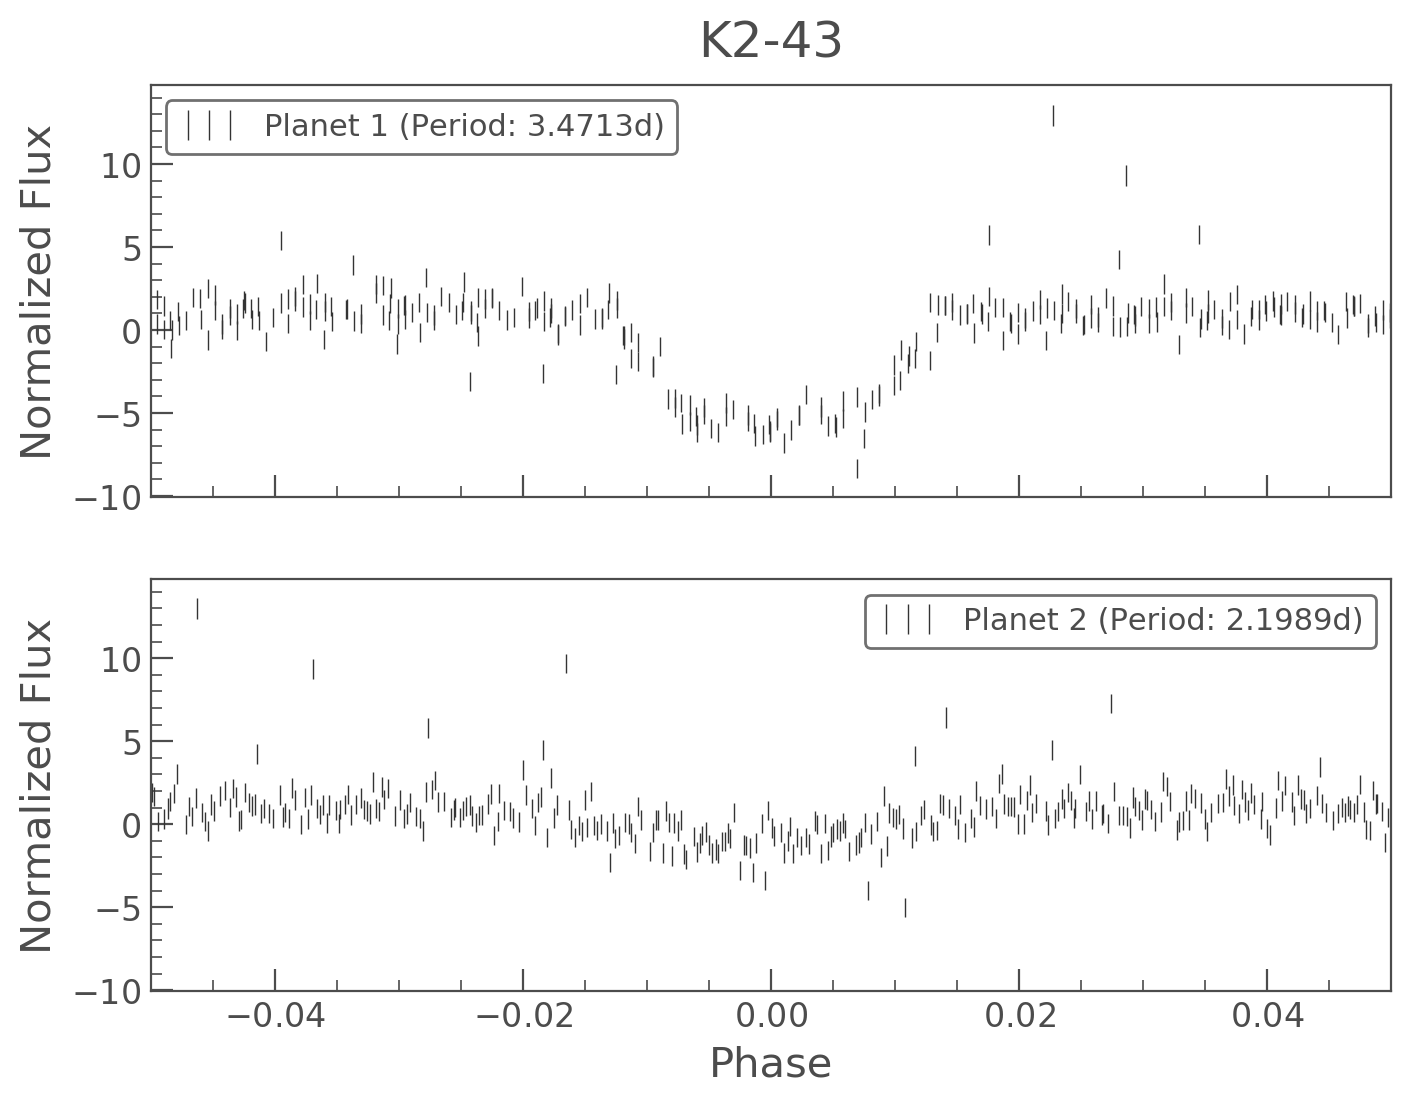

In [30]:
threemultis.utils.planet_plot(clc, 'K2-43');

In [25]:
params = threemultis.utils.get_params('K2-43')

In [57]:
trace, mask = threemultis.fit.fit_planets(clc, period_value=list(params['Period']),
                                            t0_value=list(params['T0']), depth_value=list(params['Depth']),
                                            R_star=(params.loc[0, 'R_star'], params.loc[0, 'R_star_error']),
                                            M_star=(params.loc[0, 'M_star'], params.loc[0, 'M_star_error']),
                                            T_star=(params.loc[0, 'T_star'], params.loc[0, 'T_star_error']), ndraws=200)

Sampling 4 chains: 100%|██████████| 800/800 [02:11<00:00,  8.53draws/s]
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
There were 186 divergences after tuning. Increase `target_accept` or reparameterize.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
params = threemultis.utils.get_params('K2-43')
fig, axs = plt.subplots(len(params), 1, figsize=(8, 3 * len(params)), sharex=True)
for planet, df in params.iterrows():
    otherplanets = list(set(list(np.arange(len(params)))) - set([planet]))
    mask = np.ones(len(clc.time), bool)
    for op in otherplanets:
        p1 = params.loc[op, 'Period']
        t01 = params.loc[op, 'T0']
        d1 = params.loc[op, 'Duration']
        x_fold = (clc.time - t01 + 0.5*p1) % p1 - 0.5*p1
        mask &= (np.abs(x_fold) > d1/2)

    p = df['Period']
    t0 = df['T0']
    d = df['Duration']
    x_fold = (clc.time - t0 + 0.5*p) % p - 0.5*p
    f = clc[tmmask & mask].fold(p, t0).bin(1)
    f.errorbar(ax=axs[planet], label='Planet {} (Period: {:2.4f}d)'.format(planet + 1, p))

    if planet < len(params) - 1:
        axs[planet].set_xlabel('')
    axs[planet].set_xlim(-0.05, 0.05)
    if planet == 0:
        axs[planet].set_title('K2-43')
    mlc = lk.LightCurve(clc[tmmask].time, map_soln["light_curves"][:, planet] + 1)
    mlc.fold(p, t0).plot(ax=axs[planet])

In [ ]:
import pymc3 as pm
import corner
import astropy.units as u
varnames = varnames=["r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl__0"] = (np.array(samples["r_pl__0"]) * u.R_sun).to(u.R_earth).value
samples["r_pl__1"] = (np.array(samples["r_pl__1"]) * u.R_sun).to(u.R_earth).value


corner.corner(samples);

In [ ]:
fig = threemultis.utils.plot_folded_transits(clc, trace, mask, 'K2-43');
fig.savefig('figures/K2-43.png', dpi=150, bbox_inches='tight')

In [58]:
threemultis.PACKAGEDIR

'/Users/ch/K2/projects/threemultis/threemultis'